# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Universidad Nacional de Córdoba
---

### Importación de librerías

In [1]:
import warnings
import datetime
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBClassifier

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared
from sklearn.impute import SimpleImputer

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

### Lectura del dataset 

In [2]:
df = pd.read_parquet('df_supervisado_agrupado.parquet')
df

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,000f0b73ebfa002a79a0642b82e87919904,202101.0,64.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11616.45
7406,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68
7407,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08
7408,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64


Ordenamos nuestro conjunto de datos en función a la variable anio_mes_cupon.

In [3]:
df = df.sort_values(by = ['anio_mes_cupon'], ascending = True)

In [4]:
df['monto_ajustado'].describe().round(2)

count      7410.00
mean      11808.44
std       14823.98
min      -14160.39
25%         987.78
50%        6373.59
75%       17248.53
max      134045.42
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

### Distribución de features numericas con respecto al target, monto_ajustado

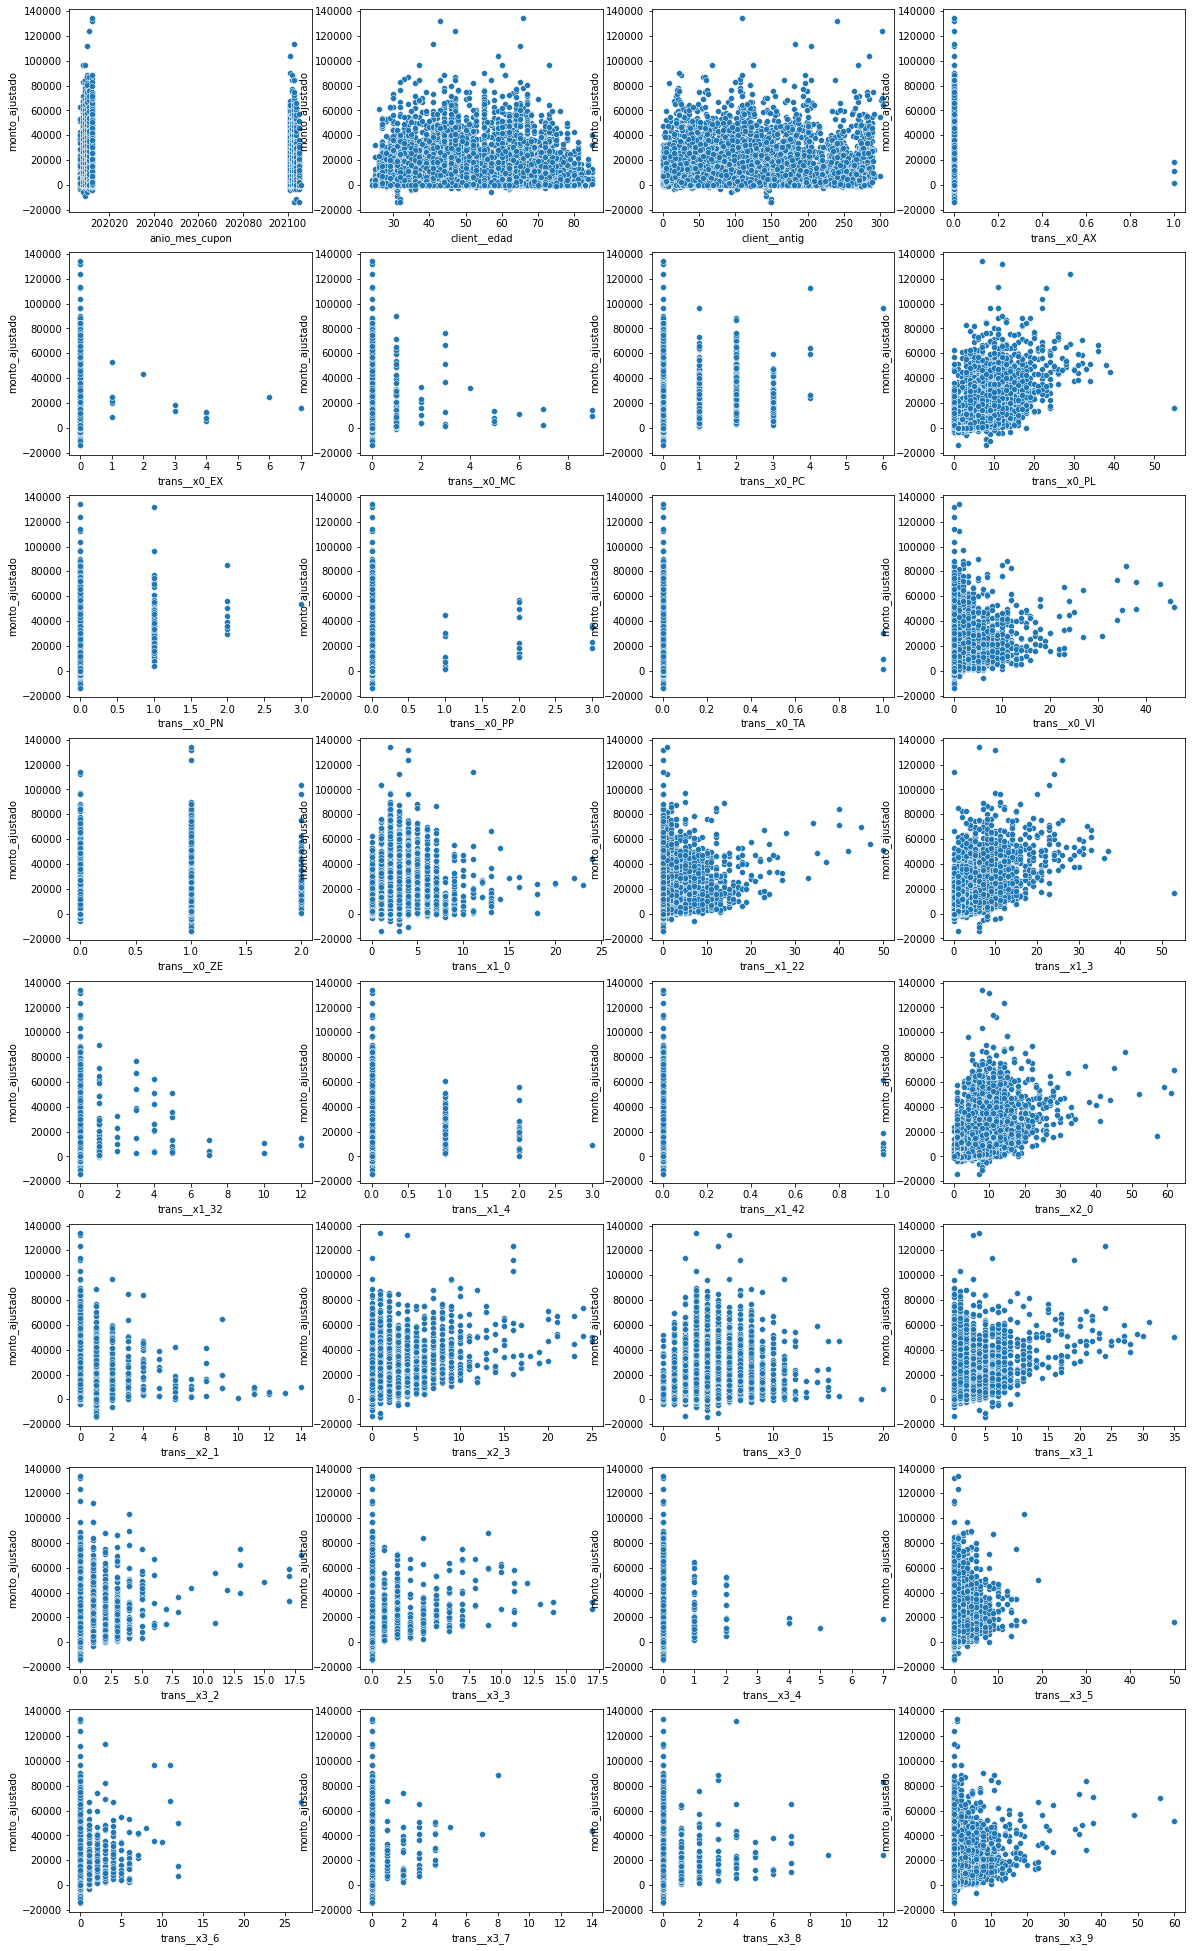

In [5]:
# Visualizamos solo las numericas y las transaccionales sumarizadas
cols = [x for x in df.columns.values if 'client__x' not in x]
cols.remove('dni_titular_movimiento')
#cols.remove('anio_mes_cupon')
cols.remove('monto_ajustado')

# plot
n_cols = 4
n_rows = math.ceil(len(cols)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 35))
count = 0
for i in cols:    
    row = math.floor(count / n_cols)
    col = count % n_cols
    ax = axs[row, col]
    sns.scatterplot(data=df, x=i, y='monto_ajustado', ax=ax)
    count =count +1

plt.show()

Analisis de distribucion de monto_ajustado con respecto a los features numericos

- **fecha_cupon_movimiento**: No hay una relacion visible. Los puntos estan distribuidos mayoritariamente en el rango entre 0 y 20000 para casi todos los meses presentes con excepcion del primer mes donde la cantidad de casos baja con respecto al resto de los meses.
- **edad_cliente**: Similar a fecha, la mayor parte de los montos se concentra entre 0 y 20000. Algo a destacar es que a medida que la edad supera los 60 años, la cantidad de transacciones baja. El grueso de transacciones estan concentradas en edades menores a 70
- **antiguedad_cliente**: A partir de la antiguedad 200, se puede observar que la cantidad de transacciones baja, lo cual podria explicarse en base a que hay menos clientes con antiguedad tan alta. Sin embargo, se puede llegar a ver una aplanacion mas paulatina de los casos que en el caso de la edad. Despues de cierta antiguedad la cantidad de transacciones baja pero se mantiene en una meseta, en cambio en el caso de la edad la baja es mas abrupta.

El scatterplot de features categoricos nos brinda unicamente informacion sobre la concentracion de casos en cada categoria, pero no podriamos con eso solo proyectar el comportamiento de las regresiones para la prediccion de los montos. 

### Balanceo de DataFrame

La cantidad de filas debería ser igual para cada mes. Cada cliente dentro del dataset debería tener al menos una transacción dentro de cada mes, y si no la tiene entonces debería tener una con todos 0 en las variables de transaccion. Con esto tendriamos un dataset balanceado. 

In [6]:
df['dni_titular_movimiento'].nunique() * df['anio_mes_cupon'].nunique() # dnis x cantidad de meses

9852

Corroboramos aquellos titulares que no tienen movimientos en todos los meses

In [7]:
df[['dni_titular_movimiento','anio_mes_cupon']].drop_duplicates().groupby(['dni_titular_movimiento']).size().reset_index(name='counts').sort_values(by='counts')

,dni_titular_movimiento,counts
354,0006b827182be3790f4983851eae6a72301,1
27,000071f1f7541835440a7b95e8280add842,1
703,000ce0a075eb02ff2decefb5d5d477b6069,1
487,00092d5c893e1a689d88d96ab217ae12832,1
744,000d825001c54cde70e79c2c0c2ca144103,1
...,...,...
371,00070a4981542ed6aaca3e1187ba82a0293,11
675,000c871be99df761652d9c7e531e05cb027,11
177,0002ec99c87c40ea558370277c2af620206,11
522,0009d755757673758d8a50f3e0a7d346850,11


In [8]:
array_mes = df.anio_mes_cupon.sort_values().unique()
array_dni = df.dni_titular_movimiento.unique()

dic = {'dni': [], 'mes': []}
for dni in array_dni:
    for mes in array_mes:
        dic['dni'].append(dni)
        dic['mes'].append(mes)

df_mes_imp = pd.merge(pd.DataFrame(dic), 
                      df, 
                      left_on=['dni','mes'], 
                      right_on=['dni_titular_movimiento','anio_mes_cupon'], 
                      how='left') \
                .drop(columns=['dni_titular_movimiento','anio_mes_cupon'])
df_mes_imp = df_mes_imp.rename(columns={'dni': 'dni_titular_movimiento','mes': 'anio_mes_cupon'})
df_mes_imp

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
0,0001ad171f1562c43ff9d73795e851be920,202007.0,40.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4521.11
1,0001ad171f1562c43ff9d73795e851be920,202008.0,40.0,42.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3361.68
2,0001ad171f1562c43ff9d73795e851be920,202009.0,40.0,43.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4432.64
3,0001ad171f1562c43ff9d73795e851be920,202010.0,40.0,44.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,8452.73
4,0001ad171f1562c43ff9d73795e851be920,202011.0,40.0,45.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12923.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,00073e893b40d39e8be8bf7e74c51737985,202102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9848,00073e893b40d39e8be8bf7e74c51737985,202103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9849,00073e893b40d39e8be8bf7e74c51737985,202104.0,36.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1363.44
9850,00073e893b40d39e8be8bf7e74c51737985,202105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Imputamos 0 en las columnas de la transacción que tienen nan
cols = df_mes_imp.columns.values
cols_zero = [x for x in cols if 'trans' in x]
cols_zero.append('monto_ajustado')
df_mes_imp[cols_zero] = df_mes_imp[cols_zero].fillna(0)

# Imputamos lo valores propios del cliente
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
cols_client = [x for x in cols if ('client_' in x) & ('antig' not in x) & ('edad' not in x)]
df_mes_imp[cols_client] = imputer.fit_transform(df_mes_imp[cols_client].values)

#Ordenamos por dni y mes
df_mes_imp = df_mes_imp.sort_values(by=['dni_titular_movimiento','anio_mes_cupon']).reset_index().drop(columns=['index'])

# Imputamos antigüedad
for dni in array_dni:
    min_mes = df_mes_imp[(df_mes_imp['dni_titular_movimiento'] == dni) & (~df_mes_imp.client__antig.isna())]['anio_mes_cupon'].min()
    min_ant = df_mes_imp[(df_mes_imp['dni_titular_movimiento'] == dni) & (~df_mes_imp.client__antig.isna())]['client__antig'].min()
    for mes in array_mes:
        num_res = array_mes.tolist().index(mes) - array_mes.tolist().index(min_mes)
        antig_cli = min_ant + num_res
        if antig_cli < 0:
            df_mes_imp.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['anio_mes_cupon'] == mes)), 'client__antig'] = 0
        else:
            df_mes_imp.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['anio_mes_cupon'] == mes)), 'client__antig'] = antig_cli

In [10]:
# Imputación Edad
df_mes_imp_eb = df_mes_imp[['dni_titular_movimiento', 'anio_mes_cupon', 'client__edad']].copy()
for dni in array_dni:
    edad = df_mes_imp_eb[df_mes_imp['dni_titular_movimiento'] == dni]['client__edad'].fillna(method='backfill')
    df_mes_imp_eb.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['client__edad'].isna())), 'client__edad'] = edad
df_mes_imp_eb = df_mes_imp_eb.rename(columns={'client__edad': 'edad_b'})

df_mes_imp_ef = df_mes_imp[['dni_titular_movimiento', 'anio_mes_cupon', 'client__edad']].copy()
for dni in array_dni:
    edad = df_mes_imp_ef[df_mes_imp['dni_titular_movimiento'] == dni]['client__edad'].fillna(method='ffill')
    df_mes_imp_ef.loc[((df_mes_imp['dni_titular_movimiento'] == dni) & (df_mes_imp['client__edad'].isna())), 'client__edad'] = edad
df_mes_imp_ef = df_mes_imp_ef.rename(columns={'client__edad': 'edad_f'})

df_mes_imp = df_mes_imp.merge(df_mes_imp_eb,
                             left_on=['dni_titular_movimiento', 'anio_mes_cupon'],
                             right_on=['dni_titular_movimiento', 'anio_mes_cupon']
                            )
df_mes_imp = df_mes_imp.merge(df_mes_imp_ef,
                             left_on=['dni_titular_movimiento', 'anio_mes_cupon'],
                             right_on=['dni_titular_movimiento', 'anio_mes_cupon']
                            )
df_mes_imp.loc[df_mes_imp['client__edad'].isna(), 'client__edad'] = df_mes_imp['edad_b']
df_mes_imp.loc[df_mes_imp['client__edad'].isna(), 'client__edad'] = df_mes_imp['edad_f']

df_mes_imp.drop(columns=['edad_b','edad_f'], inplace=True)

In [11]:
df_mes = df_mes_imp.copy()

In [12]:
ordinal_ft = 'dni_titular_movimiento'
target = 'monto_ajustado'

In [16]:
df_mes['o_mes'] = df_mes.anio_mes_cupon.astype('category').cat.codes
df_mes

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado,o_mes
0,000000b5aea2c9ea7cc155f6ebcef97f826,202007.0,46.0,224.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72,1
2,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61,2
3,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46,3
4,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68,7
9848,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08,8
9849,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64,9
9850,000f0b73ebfa002a79a0642b82e87919904,202105.0,64.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2063.81,10


# Modelos de Regresión - Predicción de consumo

## Linear SVR - Default

LinerSVR es un modelo lineal. Teniendo en cuenta las visualizaciones al principio del practico donde observamos que las features numericas no se relacionan de forma lineal con el objetivo, no podriamos esperar mucho de este modelo o cualquier modelo lineal dado el caso.

Elegimos MinMaxScaler para escalar las features numericas porque conserva el signo, y tenemos transacciones en negativo para la variable objetivo.

Usamos _SelectFromModel()_ para reducir el numero de features del dataset, y de esa manera intentar mejorar las predicciones con un costo de computo menor al que si usaramos todas las features. Para seleccionar las columnas usamos _RandomForestRegressor_

In [18]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = LinearSVR(random_state=0)

In [19]:
# Features and target
X = df.drop([ordinal_ft, target, 'anio_mes_cupon'], axis=1)
y = df[target]

In [20]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35, random_state=0, shuffle=False)

Elegimos una relacion entre train y test de un 35% para test. Esto lo hicimos en base a que en pruebas anteriores tuvimos casos donde el MSE para el conjunto de validacion era menor que en de train. Investigando sobre esto, dimos con que este problema se denomina under-fitting. Al tratarse de un modelo lineal tratando de predecir datos no lineales, este problema es esperable. Modificamos la cantidad de datos en train y test para prevenir la sobre simplificacion del modelo sobre los datos  e intentar reducir este problema. 

#### Preproceso y ajuste

In [21]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [22]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
svr = model

In [23]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [24]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 222247978.305, Valid error 223133927.157


In [25]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 14907.984, Valid error RMSE 14937.668


In [26]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 8513.375, Valid error MAE 8322.138


Visualizamos nuestra variable target (real y predicción)

In [22]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,3449.00
mean,8567.05
std,13877.86
min,-14160.00
25%,0.00
50%,2063.00
75%,12179.00
max,134045.00


In [23]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,3449.00
mean,2729.47
std,1977.39
min,-129.34
25%,1058.22
50%,2383.56
75%,4075.63
max,8877.66


## Linear SVR - Grid Search

In [24]:
param_grid = {
    'regressor__epsilon': [0.1, 0.01, 0.0001,0.001],
    'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'regressor__C': [1, 2, 0.01, 0.001],
    'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [25]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = LinearSVR(random_state=0)

In [26]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [27]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [28]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=40)

model.fit(X_train, y_train)
svr_cv = model

In [29]:
model.best_params_

{'regressor__tol': 1e-06,
 'regressor__loss': 'squared_epsilon_insensitive',
 'regressor__epsilon': 0.0001,
 'regressor__C': 0.01}

In [30]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [31]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 88537132.882, Valid error 97821131.316


In [32]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 9409.417, Valid error RMSE 9890.457


In [33]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 5830.228, Valid error MAE 5987.648


Visualizamos nuestra variable target (real y predicción)

In [34]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [35]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,9210.24
std,8825.78
min,-1335.14
25%,2261.44
50%,7060.76
75%,14038.79
max,66514.06


## SGDRegressor - Default

In [36]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [37]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [38]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [39]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [40]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
sgd = model

In [41]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [42]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 82523168.963, Valid error 92284251.802


In [43]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 9084.226, Valid error RMSE 9606.469


In [44]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 5054.513, Valid error MAE 5198.131


Visualizamos nuestra variable target (real y predicción)

In [45]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [46]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8520.43
std,10518.21
min,-1407.10
25%,-121.89
50%,5053.17
75%,13315.41
max,87793.41


## SGDRegressor- Grid Search

In [47]:
param_grid = {
    'regressor__loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'regressor__penalty': ['l2','l1'],
    'regressor__alpha': [0.01, 0.1, 1],
    'regressor__epsilon': [0.1, 0.01],
    'regressor__tol': [1e-3, 1e-4],
    'regressor__learning_rate': ['optimal', 'adaptive', 'invscaling', 'constant']
    #'max_iter': [1000, 2000, 5000]
}

In [48]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [49]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [50]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [51]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [52]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=20)

model.fit(X_train, y_train)
sgd_cv = model

In [53]:
model.best_params_

{'regressor__tol': 0.001,
 'regressor__penalty': 'l1',
 'regressor__loss': 'squared_epsilon_insensitive',
 'regressor__learning_rate': 'adaptive',
 'regressor__epsilon': 0.01,
 'regressor__alpha': 0.1}

In [54]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [55]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 82306139.001, Valid error 91972164.584


In [56]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 9072.273, Valid error RMSE 9590.212


In [57]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 5036.977, Valid error MAE 5187.875


Visualizamos nuestra variable target (real y predicción)

In [58]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [59]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8769.30
std,10608.56
min,-1024.30
25%,95.87
50%,5137.72
75%,13499.69
max,89255.90


## KNeighborsRegressor - Default

In [60]:
# Preproceso 1 para SGDRegressor - GridSearch, RMSE 3778.109
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [61]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [62]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

In [63]:
X_train.shape

(6896, 53)

In [64]:
X_val.shape

(2956, 53)

#### Preproceso y ajuste

In [65]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [66]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
knn = model

In [67]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [68]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 64110516.52, Valid error 149533736.473


In [69]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 8006.904, Valid error RMSE 12228.399


In [70]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 4202.646, Valid error MAE 6493.684


Visualizamos nuestra variable target (real y predicción)

In [71]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [72]:
pd.DataFrame(y_valid_pred.astype(int), columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,7037.76
std,8587.65
min,-662.00
25%,0.00
50%,3619.50
75%,12003.25
max,59336.00


## KNeighborsRegressor - Grid Search

In [73]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [74]:
param_grid = {
    'regressor__n_neighbors': [20,25,30,35],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto','ball_tree','kd_tree','brute'],
    'regressor__p': [1,2]
}

Elegimos valores altos de K, porque?

In [75]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [76]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [77]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [78]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
knn_cv = model

In [79]:
model.best_params_

{'regressor__algorithm': 'ball_tree',
 'regressor__n_neighbors': 25,
 'regressor__p': 1,
 'regressor__weights': 'distance'}

In [80]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [81]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 1314024.378, Valid error 135458694.72


In [82]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 1146.309, Valid error RMSE 11638.672


In [83]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 138.883, Valid error MAE 6065.512


Visualizamos nuestra variable target (real y predicción)

In [84]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [85]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,6647.09
std,7149.91
min,-1446.06
25%,0.00
50%,4627.28
75%,11162.92
max,51630.43


## GaussianProcessRegressor - Default

In [86]:
# Preproceso 1 para GaussianProcessRegressor - Default
df = df_mes.copy()
scaler = StandardScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [87]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [88]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [89]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [90]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
gpr = model

In [91]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [92]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 0.0, Valid error 268381185.757


In [93]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 0.0, Valid error RMSE 16382.344


In [94]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 0.0, Valid error MAE 8651.56


Visualizamos nuestra variable target (real y predicción)

In [95]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [96]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,30.64
std,141.51
min,-3518.41
25%,0.00
50%,0.59
75%,13.47
max,2886.17


## GaussianProcessRegressor - Grid Search 

In [97]:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf, ker_rq, ker_expsine]

param_grid = {"regressor__kernel": kernel_list,
              "regressor__alpha": [0.1]}

In [98]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = StandardScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [99]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [100]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [101]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [134]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, verbose=2)

model.fit(X_train, y_train)
gpr_cv = model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.5s


In [103]:
model.best_params_

{'regressor__alpha': 0.1,
 'regressor__kernel': 1**2 * RationalQuadratic(alpha=0.1, length_scale=1)}

In [104]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [105]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 1065686.456, Valid error 123107392.722


In [106]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 1032.321, Valid error RMSE 11095.377


In [107]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 612.349, Valid error MAE 6956.474


Visualizamos nuestra variable target (real y predicción)

In [108]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [109]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,8918.06
std,6540.76
min,-37.05
25%,3501.23
50%,7788.73
75%,13300.67
max,32530.97


## XGBRegressor - Default

In [110]:
# Preproceso 1 para XGBRegressor - Default
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = XGBRegressor(random_state=0, verbosity=1)

In [111]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [112]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

#### Preproceso y ajuste

In [113]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [114]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
xgb = model

In [115]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [116]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 24321072.59, Valid error 87365458.226


In [117]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 4931.64, Valid error RMSE 9346.949


In [118]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 2559.054, Valid error MAE 4927.354


Visualizamos nuestra variable target (real y predicción)

In [119]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,1971.00
mean,8924.49
std,13879.06
min,-6072.00
25%,0.00
50%,2742.00
75%,12205.50
max,96811.00


In [120]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,1971.00
mean,8980.89
std,11425.97
min,-1741.53
25%,0.56
50%,5279.18
75%,14184.06
max,75653.95


## XGBRegressor - Grid Search

In [121]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
model_ = XGBRegressor(random_state=0)#, booster='gbtree')

La combinacion de hiperparametros es mas densa en este modelo porque fue el que mejor resultados dio en cuanto a RMSE

In [122]:
#param_grid = {'regressor__max_depth': [None]}
#              'regressor__eta': [0.15, 0.1, 0.08],
           #   'regressor__subsample': [None],
           #   'regressor__colsample_bytree': [None]}
param_grid = {}    

In [123]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [124]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [125]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [126]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1)

model.fit(X_train, y_train)
xgb_cv = model

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [127]:
model.best_params_

{}

In [128]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [129]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 15359603.337, Valid error 95092621.527


In [130]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 3919.133, Valid error RMSE 9751.545


In [131]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 2138.908, Valid error MAE 5376.028


Visualizamos nuestra variable target (real y predicción)

In [132]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,1971.00
mean,8188.97
std,13595.32
min,-14160.00
25%,0.00
50%,2003.00
75%,11224.50
max,123807.00


In [133]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,1971.00
mean,9072.64
std,11677.59
min,-5265.74
25%,61.69
50%,4979.42
75%,14167.92
max,70696.34


## VotingRegressor

In [135]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = VotingRegressor([#('svr', svr['regressor']),
                      #    ('sgd', sgd['regressor']),
                          ('knn', knn['regressor']),
                          ('gpr', gpr['regressor']),
                          ('xgb', xgb['regressor']),
                          ('knn_cv', knn_cv.best_estimator_['regressor']),
                          ('gpr_cv', gpr_cv.best_estimator_['regressor']),
                          ('xgb_cv', xgb_cv.best_estimator_['regressor'])], verbose=True)

In [136]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [137]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [138]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [139]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)

[Voting] ...................... (1 of 6) Processing knn, total=   0.0s
[Voting] ...................... (2 of 6) Processing gpr, total=  18.5s
[Voting] ...................... (3 of 6) Processing xgb, total=   0.7s
[Voting] ................... (4 of 6) Processing knn_cv, total=   0.1s
[Voting] ................... (5 of 6) Processing gpr_cv, total=   0.7s
[Voting] ................... (6 of 6) Processing xgb_cv, total=   0.7s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['anio_mes_cupon',
                                                   'trans__x0_AX',
                                                   'trans__x0_EX',
                                                   'trans__x0_MC',
                                                   'trans__x0_PC',
                                                   'trans__x0_PL',
                                                   'trans__x0_PN',
                                                   'trans__x0_PP',
                                                   'trans__x0_TA',
                                                   'trans__x0_VI',
                                                   'trans__x0_ZE',
                                                   'trans__x1_0',
                                                   'trans__x1_22',
                      

#### Evaluacion de predicciones

In [140]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

In [141]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 7966483.854, Valid error 118497188.357


In [142]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 2822.496, Valid error RMSE 10885.641


In [143]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 1690.848, Valid error MAE 5990.508


Visualizamos nuestra variable target (real y predicción)

In [144]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2956.00
mean,8594.33
std,13961.94
min,-14160.00
25%,0.00
50%,2101.50
75%,11986.50
max,134045.00


In [145]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2956.00
mean,7003.70
std,6389.89
min,-785.95
25%,1974.70
50%,5281.90
75%,10452.03
max,48131.38


# Modelos de Clasificacion - Predecir aumento de gasto mensual

## Preprocesamiento

### 1.2 Creación de variable categórica 

Creamos una columna que indica si un cliente ha aumentado su consumo personal mes a mes. El mes inicial para cada cliente se inicializa en 0.

Cabe destacar que a la hora de agrupar los movimientos en cada mes, se considera la fecha de cierre de la tarjeta, por lo cual cada mes comprende desde el dia 25 del mes anterior hasta el dia 24 del corriente, inclusive. 

In [146]:
df_mes

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202007.0,46.0,224.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72
2,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61
3,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46
4,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68
9848,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08
9849,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64
9850,000f0b73ebfa002a79a0642b82e87919904,202105.0,64.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2063.81


In [147]:
# Agregación de la nueva columna seteada en 0.
# En la iteración, se le cambia el valor a 1 en caso de que cumpla con las condiciones preestablecidas.

df_mes['fg_aumentado'] = 0
for i in range(1,len(df_mes)):
    if (df_mes.iloc[i]['dni_titular_movimiento'] == df_mes.iloc[i-1]['dni_titular_movimiento']) \
        & (df_mes.iloc[i]['anio_mes_cupon'] > df_mes.iloc[i-1]['anio_mes_cupon']):
            var_mes = df_mes.iloc[i]['monto_ajustado'] - df_mes.iloc[i-1]['monto_ajustado']
            if (var_mes > (abs(df_mes.iloc[i-1]['monto_ajustado'])*0.1)):
                df_mes.loc[i,'fg_aumentado'] = 1

In [200]:
df_mes.head(24)

,dni_titular_movimiento,anio_mes_cupon,client__edad,client__antig,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202007.0,46.0,224.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34,0
5,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21,0
6,000000b5aea2c9ea7cc155f6ebcef97f826,202101.0,47.0,230.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.08,0
7,000000b5aea2c9ea7cc155f6ebcef97f826,202102.0,47.0,231.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.97,0
8,000000b5aea2c9ea7cc155f6ebcef97f826,202103.0,47.0,232.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.83,0
9,000000b5aea2c9ea7cc155f6ebcef97f826,202104.0,47.0,233.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.72,0


In [149]:
df = df_mes.copy() # Usamos siempre df_mes para clasificar

## RandomForestClassifier - Default

In [152]:
target_c = 'fg_aumentado'

In [153]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
ft_selector = RandomForestClassifier(random_state=0)
model_ = RandomForestClassifier(random_state= 0, max_depth=20, min_samples_split=20)

In [154]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [155]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [156]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [157]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
rfc = model

In [158]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

In [159]:
model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                    ['anio_mes_cupon', 'trans__x0_AX',
                                     'trans__x0_EX', 'trans__x0_MC',
                                     'trans__x0_PC', 'trans__x0_PL',
                                     'trans__x0_PN', 'trans__x0_PP',
                                     'trans__x0_TA', 'trans__x0_VI',
                                     'trans__x0_ZE', 'trans__x1_0', 'trans__x1_22',
                                     'trans__x1_3', 'trans__x1_32', 'trans__x1_4',
                                     'trans__x1_42', 'trans__x2_0', 'trans__x2_1',
                                     'trans__x2_3'...
                                     'client__x1_Sector_Operativo',
                                     'client__x1_Sector_Salud',
                                     'client__x1_Sector_Seguridad',
                                     'client_

#### Evaluacion de predicciones

In [160]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4764
           1       0.88      0.80      0.84      2132

    accuracy                           0.90      6896
   macro avg       0.90      0.88      0.89      6896
weighted avg       0.90      0.90      0.90      6896



In [161]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2015
           1       0.71      0.65      0.68       941

    accuracy                           0.80      2956
   macro avg       0.77      0.76      0.77      2956
weighted avg       0.80      0.80      0.80      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

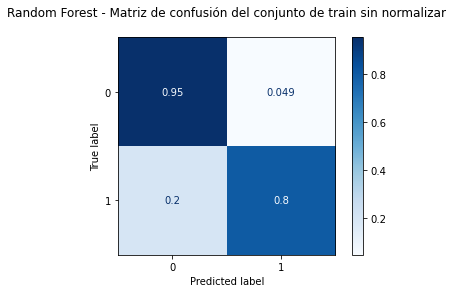

In [162]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

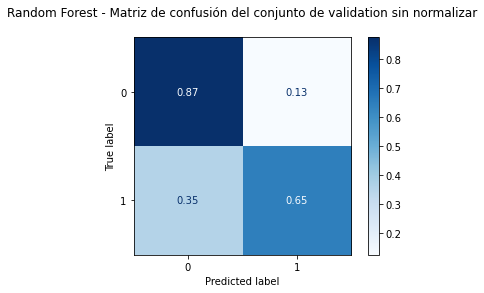

In [163]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## RandomForestClassifier - Grid Search

In [164]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = RandomForestClassifier(random_state= 0)

In [165]:
param_grid = {'cla__n_estimators' : [75, 100],
                'cla__criterion':['gini', 'entropy'],
                'cla__max_depth': [20, 25],
                'cla__min_samples_split': [20, 25],
                'cla__min_samples_leaf':[5, 6, 8],
                'cla__max_features':[0.5, 0.7, 0.8]}

In [166]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [167]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [168]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [169]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
rfc_cv = model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [170]:
model.best_params_

{'cla__n_estimators': 100,
 'cla__min_samples_split': 20,
 'cla__min_samples_leaf': 5,
 'cla__max_features': 0.5,
 'cla__max_depth': 25,
 'cla__criterion': 'entropy'}

In [171]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [172]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4764
           1       0.89      0.80      0.84      2132

    accuracy                           0.91      6896
   macro avg       0.90      0.88      0.89      6896
weighted avg       0.91      0.91      0.91      6896



In [173]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2015
           1       0.71      0.65      0.68       941

    accuracy                           0.80      2956
   macro avg       0.77      0.76      0.77      2956
weighted avg       0.80      0.80      0.80      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

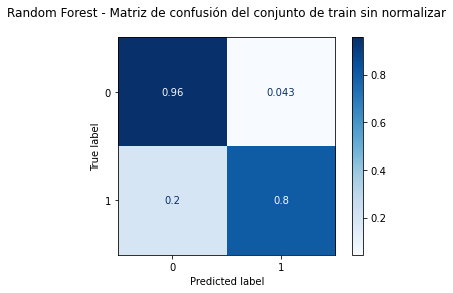

In [174]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

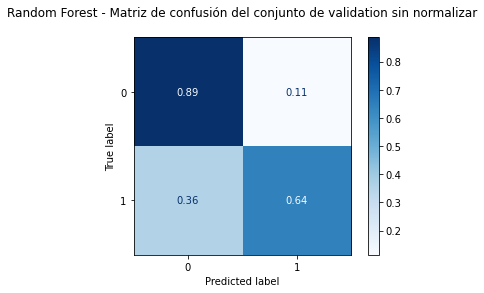

In [175]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Default

In [176]:
# Preproceso 1 para XGBClassifier - Default
scaler = MaxAbsScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0)

In [177]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [178]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [179]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [180]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
xgbc = model

[09:38:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [181]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [182]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      4764
           1       0.88      0.76      0.82      2132

    accuracy                           0.89      6896
   macro avg       0.89      0.86      0.87      6896
weighted avg       0.89      0.89      0.89      6896



In [183]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2015
           1       0.62      0.55      0.58       941

    accuracy                           0.75      2956
   macro avg       0.71      0.70      0.70      2956
weighted avg       0.74      0.75      0.75      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

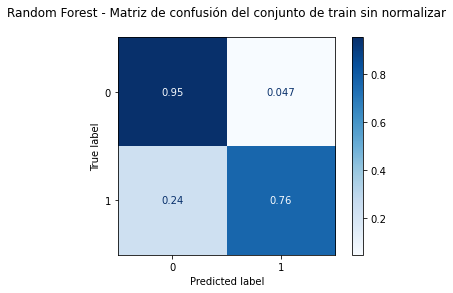

In [184]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

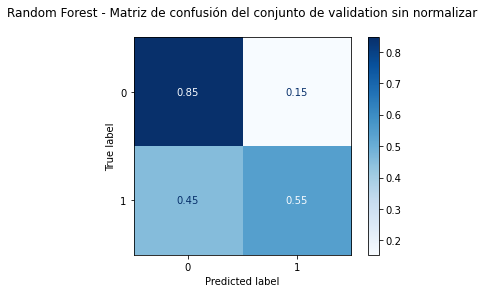

In [185]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Grid Search

In [186]:
# Preproceso 1 para SGDRegressor - Default
scaler = MaxAbsScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0, use_label_encoder=False)

In [187]:
param_grid = {
    'cla__alpha' : [0.01, 0.42, 0.30],
    'cla__max_depth': [8, 16, 32],
    'cla__n_estimators': [5, 10, 15],
    'cla__booster':['gbtree', 'dart'],
    'cla__eval_metric': ['mlogloss']
}

In [188]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [189]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [190]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [191]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
xgbc_cv = model

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [192]:
model.best_params_

{'cla__alpha': 0.42,
 'cla__booster': 'gbtree',
 'cla__eval_metric': 'mlogloss',
 'cla__max_depth': 8,
 'cla__n_estimators': 10}

In [193]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [194]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4764
           1       0.80      0.73      0.77      2132

    accuracy                           0.86      6896
   macro avg       0.84      0.83      0.83      6896
weighted avg       0.86      0.86      0.86      6896



In [195]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      2015
           1       0.62      0.55      0.58       941

    accuracy                           0.75      2956
   macro avg       0.71      0.70      0.70      2956
weighted avg       0.74      0.75      0.75      2956



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

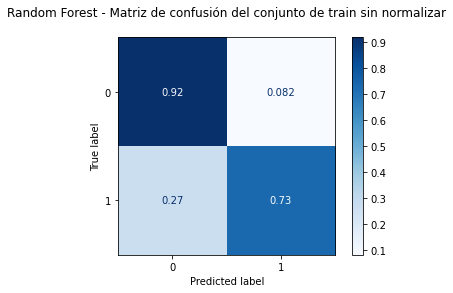

In [196]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

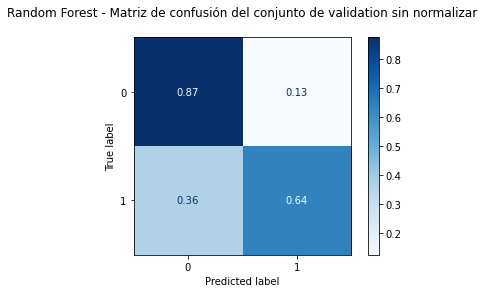

In [197]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [198]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

0.12.2


In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

In [ ]:
df_encode.columns

In [ ]:
sf1 = df_encode[['fecha_cupon_movimiento', 'monto_ajustado', 'trans__x0_PL']]
sf2 = df_encode[['fecha_cupon_movimiento', 'monto_ajustado', 'trans__x0_VI']]

In [ ]:
# Agrupa por fecha todos los montos para Plan Largo
cols = ['fecha_cupon_movimiento', 'monto']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [ ]:
sf.reset_index(inplace=True)
sf

In [ ]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

In [ ]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

En series temporales se usa Series en lugar de Dataframe

In [ ]:
ss = sf['monto_compra_movimiento']
ss

In [ ]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [ ]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [ ]:
print(y_test.index.max())
print(y_test.index.min())

In [ ]:
print(y_train.index.max())
print(y_train.index.min())

## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


In [ ]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [ ]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

In [ ]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

In [ ]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)